In [73]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
from torch.nn.functional import conv1d, mse_loss
from torchcontrib.optim import SWA
import torch.nn as nn

from tqdm import tqdm
import mir_eval

from IPython.display import Audio

%matplotlib inline

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [3]:
# lvl1 convolutions are shared between regions
m = 128
k = 500              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 15, 'pin_memory': True, 'worker_init_fn': worker_init}

In [4]:
start = time()
root = '../data/'
test_set = musicnet.MusicNet(root=root, train=False, download=True, refresh_cache=False, window=window, epoch_size=50000, mmap=False)
print("Time used = ", time()-start)

Time used =  0.4340245723724365


In [5]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [6]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="stft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos

def create_filtersv2(n_fft, freq_bins=None, low=50,high=5500, sr=44100, freq_scale='linear', mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    

    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        
    if freq_scale == 'linear':
        start_bin = start_freq*n_fft/sr
        scaling_ind = (end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
    elif freq_scale == 'log':
        start_bin = start_freq*n_fft/sr
        scaling_ind = np.log(end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)    
    else:
        print("Please select the correct frequency scale, 'linear' or 'log'")
    
    return wsin,wcos



In [7]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [8]:
class Model(torch.nn.Module):
    def __init__(self, mode='fft', freq_scale='linear', avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, mode=mode, freq_scale=freq_scale)
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.cuda().data for parm in self.parameters())) 

        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        return torch.log(zx + 10e-8)
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Showing flatten features

In [34]:
model = Model()
model.cuda()

Model(
  (linear): Linear(in_features=12500, out_features=128, bias=True)
)

In [35]:
test_set.rec_ids

[2556, 2303, 2382, 2416, 2191, 2298, 2106, 2628, 1819, 1759]

In [36]:
with test_set:
    X, Y = test_set.access(2303, 50000)
Audio(X, rate=44100)    

In [41]:
X = torch.tensor(X.reshape(1,-1)).cuda()

In [43]:
SpecX = model(X)

(-0.5, 0.5, -0.5, 12499.5)

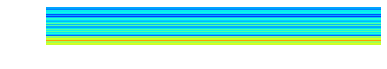

In [44]:
plt.imshow(SpecX.view(-1,1).cpu(), aspect=0.000009, cmap='jet', origin='lower')
# plt.colorbar()
# plt.xlabel('time step')
# plt.ylabel('frequency bin')
plt.axis('off')

# Showing spectrogram

In [50]:
model = Model(mode='stft', freq_scale='linear')
model.cuda()
with test_set:
    X, Y = test_set.access_full(2303)
X = torch.tensor(X.reshape(1,-1)).cuda()
SpecX = model(X)

Text(0, 0.5, 'frequency bin')

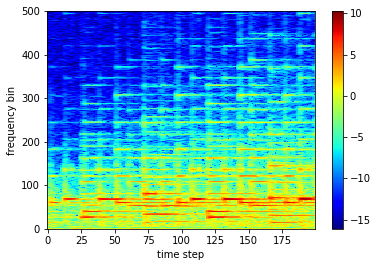

In [51]:
plt.imshow(SpecX[0][:,100:300].cpu(), cmap='jet', origin='lower', aspect='auto')#,vmax=10, vmin=-16)
plt.colorbar()
plt.xlabel('time step')
plt.ylabel('frequency bin')
# plt.axis('off')

# Showing spectrogram for 1 audio ssegment (16k samples)

Text(0, 0.5, 'frequency bin')

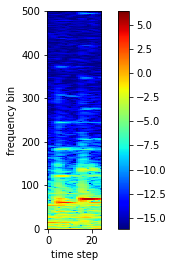

In [62]:
model = Model(mode='stft', freq_scale='linear')
model.cuda()
with test_set:
    X, Y = test_set.access(2303,50000)
X = torch.tensor(X.reshape(1,-1)).cuda()
SpecX = model(X)

plt.imshow(SpecX[0].cpu(), cmap='jet', origin='lower', aspect=0.2)#,vmax=10, vmin=-16)
plt.colorbar()
plt.xlabel('time step')
plt.ylabel('frequency bin')
# plt.axis('off')

# Doing Convolutions

## Part 1 Freq Kernal

In [74]:
k_out = 128
k2_out = 256
stride1 = (2,1)
CNN_freq = nn.Conv2d(1,k_out,kernel_size=(128,1),stride=(2,1))
CNN_time = nn.Conv2d(k_out,k2_out,kernel_size=(1,25),stride=(1,1))

In [81]:
output = CNN_freq(SpecX.unsqueeze(1))

In [84]:
output[0].shape

torch.Size([128, 187, 25])

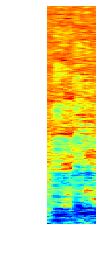

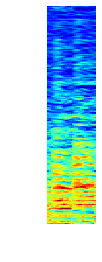

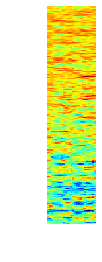

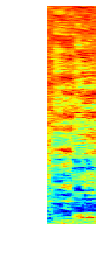

In [96]:
for i in [0,1,2,-1]:
    plt.imshow(output[0][i].data.cpu(), cmap='jet', origin='lower', aspect=0.6)#,vmax=10, vmin=-16)
    plt.xlabel('time step')
    plt.ylabel('frequency bin')
    plt.axis('off')
    plt.show()

In [99]:
output_t = CNN_time(output)

In [107]:
output_t.shape

torch.Size([1, 256, 187, 1])

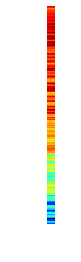

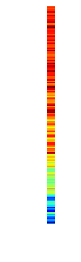

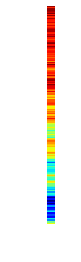

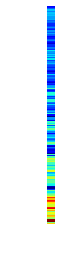

In [109]:
for i in [0,1,2,-1]:
    plt.imshow(output_t[0][i].data.cpu(), cmap='jet', origin='lower', aspect=0.15)#,vmax=10, vmin=-16)
    plt.xlabel('time step')
    plt.ylabel('frequency bin')
    plt.axis('off')
    plt.show()

In [119]:
torch.flatten(output_t).shape

torch.Size([47872])

(-0.5, 0.5, -0.5, 47871.5)

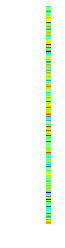

In [126]:
plt.imshow(output_t.view(-1,1).data.cpu(), cmap='jet', origin='lower', aspect=0.001)#,vmax=10, vmin=-16)
plt.axis('off')